In [1]:
import os
import sys
#from google.colab import drive
#drive.mount('./content')
os.chdir("/content/drive/MyDrive/Colab Notebooks/joi")
sys.path.append("/content/drive/MyDrive/Colab Notebooks/joi")

In [2]:
!unzip metadata.zip

Archive:  metadata.zip
  inflating: metadata.csv            


In [4]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.3 MB 9.3 MB/s 
     |████████████████████████████████| 163 kB 67.9 MB/s 
     |████████████████████████████████| 7.6 MB 47.1 MB/s 


In [5]:
import torch
import numpy as np
import pandas as pd
from transformers import AutoTokenizer, AutoModel
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import DBSCAN,KMeans
from sklearn.neighbors import NearestNeighbors

from tqdm import tqdm

from torch.utils.tensorboard import SummaryWriter

In [6]:
data_dir = '2022-06-02'

In [7]:
all_metadata = pd.read_csv(f"metadata.csv",low_memory=False)

In [8]:
texts = all_metadata['title'].to_list()+all_metadata['abstract'].to_list()

In [9]:
texts = list(filter(lambda x : not pd.isna(x) ,texts))

In [10]:
vectorizer = CountVectorizer(min_df=500,max_df=0.25,stop_words='english')
X = vectorizer.fit_transform(texts)

In [11]:
word_cnt = np.array(X.sum(0)).flatten()

In [12]:
word_cnt = sorted(dict(zip(vectorizer.get_feature_names(),word_cnt)).items(),key=lambda x:x[1],reverse=True)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [13]:
word_cnt = list(filter(lambda x:len(x[0])>4,word_cnt))

In [14]:
words = list(map(lambda x:x[0],word_cnt))

In [15]:
from nltk.corpus import wordnet as wn

In [19]:
import nltk

In [22]:
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_ru.zip.
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping grammars/basque_grammars.zip.
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/biocreative_ppi.zip.
[nltk_data]    | Downloadin

True

In [20]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [24]:
nouns = []
for w in words:
    try:
        syn = wn.synsets(w)
        if type(syn) == type([]):
            flag = syn[0].pos()=='n'
        else:
            flag = syn.pos()=='n'
    except:
        print(w)
    if flag:
        nouns.append(w)

coronavirus
versus
multi
telemedicine
comorbidities
vitro
telehealth
coronaviruses
dataset
pubmed
laparoscopic
biomarkers
socio
burnout
covid19
genomic
nucleic
datasets
remdesivir
multivariable
psychosocial
pandemia
embase
seroprevalence
frontline
bnt162b2
tocilizumab
multidisciplinary
cochrane
multicenter
mellitus
opioid
silico
nanoparticles
sociodemographic
scoping
thrombotic
infectivity
comorbidity
nucleocapsid
pacientes
pathophysiology
intra
tmprss2
clinicaltrials
hubei
policymakers
scopus
microbiota
biomarker
repurposing
keywords
preprint
entre
prospectively
smartphone
dengan
multisystem
extracorporeal
pfizer
mitochondrial
perioperative
endovascular
interquartile
univariate
convolutional
preterm
listserv
dalam
autophagy
pneumoniae
sobre
whilst
immunomodulatory
interventional
microbiome
psycinfo
lopinavir
syncytial
troponin
penelitian
crispr
transmissibility
untuk
coagulopathy
transcriptional
dehydrogenase
pandemi
intraoperative
creatinine
aureus
facebook
bioactive
saúde
salud
mese

In [25]:
len(nouns)

6308

In [26]:
def scibert():
    tokenizer = AutoTokenizer.from_pretrained("allenai/scibert_scivocab_uncased")
    model = AutoModel.from_pretrained("allenai/scibert_scivocab_uncased")
    return tokenizer,model

In [27]:
if torch.cuda.is_available():
  device = torch.device("cuda")
else: 
  device = torch.device("cpu")

In [28]:
tokenizer,model = scibert()
model.to(device)
model.eval()

Downloading:   0%|          | 0.00/385 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/228k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/442M [00:00<?, ?B/s]

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(31090, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

In [30]:
with torch.no_grad():
    results = []
    for w in tqdm(nouns):
        inputs = tokenizer([w], padding=False, truncation=False, return_tensors="pt",add_special_tokens=False)
        input_ids = inputs['input_ids'].to(device)
        token_type_ids = inputs['token_type_ids'].to(device)
        attention_mask = inputs['attention_mask'].to(device)
        out = model(input_ids = input_ids, token_type_ids=token_type_ids, attention_mask=attention_mask).last_hidden_state.mean(1)
#         print(out.shape)
        results.append(out)
results = torch.cat(results,dim=0).cpu().numpy()

100%|██████████| 6308/6308 [03:24<00:00, 30.84it/s]


In [31]:
X_tsne = TSNE(n_components=2,perplexity=18,learning_rate=10,metric='cosine',n_iter=500,n_jobs=-1,random_state=29).fit_transform(results) 

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:827: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  FutureWarning,


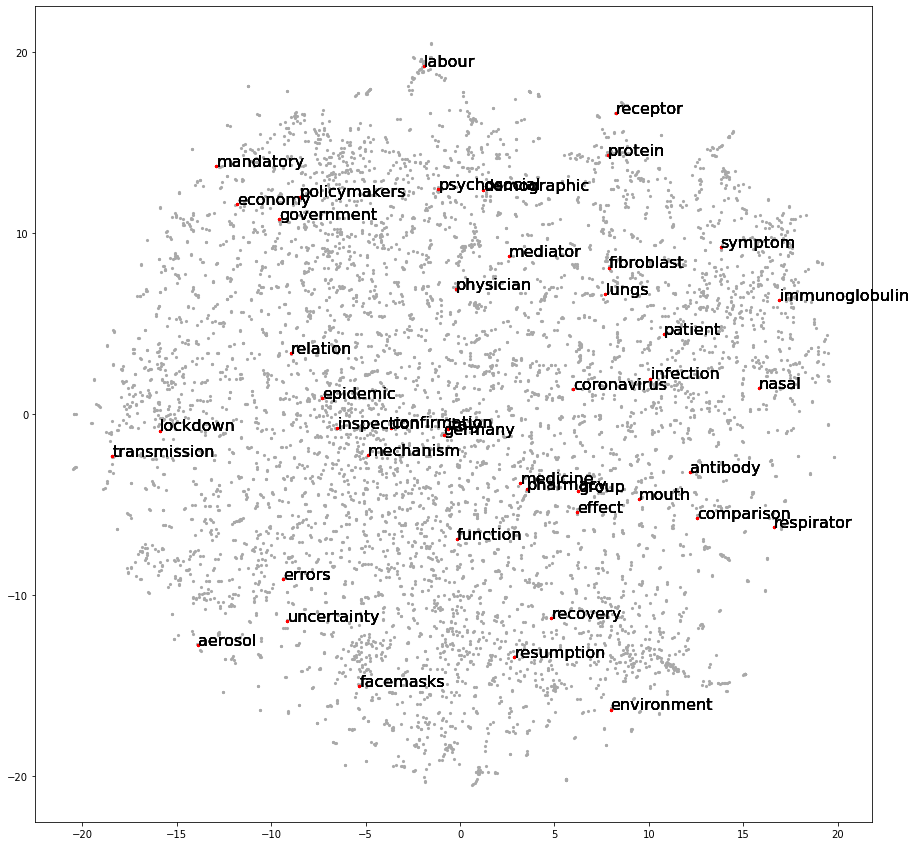

In [35]:
plt.figure(figsize=(15,15))
cords = X_tsne
x,y = cords[:,0],cords[:,1]
plt.scatter(x,y,marker='o', c='darkgrey',linewidths=0,s=10)

for fontsize in [14, 15, 16,17,18]:
    show_words = ['facemasks','respirator','infection','epidemic','pharmacy','medicine','policymakers','government',
                  'economy','labour','antibody','immunoglobulin','demographic','patient','psychosocial',
                  'symptom','function','mechanism','transmission',
                  'uncertainty','errors','lockdown','effect','comparison','group',
                 'environment','mandatory','relation','resumption','recovery',
                 'protein','receptor','aerosol','italy','germany',
                 'mouth','nasal','fibroblast','lungs','coronavirus','confirmation','inspection','physician','mediator',
    #               'explanation','reason',
                 ]
    #     'treatment','etiology','restriction','strategy',
    for idx, word in enumerate(nouns):
        if word in show_words:
            plt.scatter(x[idx],y[idx],marker='o', c='red',linewidths=0,s=10)
            plt.text(x[idx],y[idx],word,fontsize=16)
    # for i in range(-20,20):
    #     plt.plot([i,i],[-20,20])
    #     plt.plot([-20,20],[i,i])
    plt.savefig(f'word_embed.svg')
    # plt.show()